<a href="https://colab.research.google.com/github/1Un/Kaggle-Simpson/blob/main/Kaggle_simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import seaborn as sn
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print("PyTorch Version: ", torch.version)
print("Torchvision Version: ", torchvision.version)


train_on_gpu = torch.cuda.is_available()
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PyTorch Version:  <module 'torch.version' from '/usr/local/lib/python3.6/dist-packages/torch/version.py'>
Torchvision Version:  <module 'torchvision.version' from '/usr/local/lib/python3.6/dist-packages/torchvision/version.py'>
CUDA is available!  Training on GPU ...


# Journey to Springfield




 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).




---

**We take a dataset from kaggle:**
https://www.kaggle.com/c/journey-springfield/data

---



In [ ]:
#!unzip '/content/gdrive/MyDrive/DATASETS/journey-springfield.zip'
#!pip install albumentations==0.5.1

In [ ]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 25 13:15:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    11W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

Our test will have 990 cards, for which you will need to predict the class.

In [ ]:
import random

SEED = 42
def seed(SEED=42):
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
seed()

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, files, mode):
        super().__init__()
        
        self.files = sorted(files)
        
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),    
            #transforms.RandomGrayscale(),
            transforms.ColorJitter(brightness=0.5),
            transforms.RandomErasing(scale=(0.001, 0.01)),
            #transforms.RandomErasing(),
            transforms.RandomRotation(degrees=10),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        
        if self.mode == 'test':
            x = test_transform(x)
            return x
        else:
            x = train_transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

### Class Balance

As we will see below, some classes contain very few examples, in order to fix this, we will simply increase their minimum number to 300 (we will just copy the path a couple of times)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
len(train_val_files)

20933

In [ ]:
train_files_labels=[path.parent.name for path in train_val_files]
dct_simpsons=pd.DataFrame(pd.Series(train_files_labels).value_counts().sort_values())
dct_simpsons


,0
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


In [ ]:
path_class_balance={}
#k=0
for label in os.listdir(TRAIN_DIR):
  paths=sorted((TRAIN_DIR/label).rglob('*.jpg'))
  lenght=len(paths)
  if lenght<300:
    #tmp=len(paths)
    paths = paths*(300//lenght+1)  
    #k+=((300//lenght+1)-1)*(tmp)
    
  path_class_balance.update({label:paths})
#k

In [ ]:
balance_test=pd.DataFrame(index=path_class_balance.keys(),data={'0':[len(val) for val in path_class_balance.values()]}).sort_values(by='0')
balance_test

,0
lionel_hutz,303
troy_mcclure,304
disco_stu,304
miss_hoover,306
selma_bouvier,309
lenny_leonard,310
rainier_wolfcastle,315
barney_gumble,318
sideshow_mel,320
otto_mann,320


In [ ]:
train_val_files=sorted(sum(list(path_class_balance.values()),[]))
train_files_labels=[path.parent.name for path in train_val_files]

In [ ]:
len(train_val_files)

27133

In [ ]:
len(train_files_labels)

27133

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.1, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Let's take a look at our heroes inside the dataset.

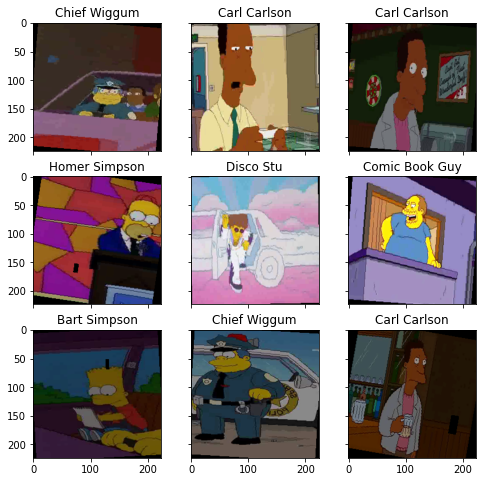

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
len(val_dataset)

2714

### Building a neural network

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes,k=8):
        super().__init__()
         
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12*k, kernel_size=3, padding=1),#224/2=112
            nn.BatchNorm2d(12*k),
            #nn.Dropout2d(p=0.7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12*k, out_channels=12*k, kernel_size=3, padding=1),#112/2=56
            nn.BatchNorm2d(12*k),
            #nn.Dropout2d(p=0.7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=12*k, out_channels=12*k, kernel_size=3, padding=2),#56/2=28
            nn.BatchNorm2d(12*k),
            #nn.Dropout2d(p=0.7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=12*k, out_channels=6*k, kernel_size=3, padding=1),#28/2=14
            nn.BatchNorm2d(6*k),
            #nn.Dropout2d(p=0.7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=6*k, out_channels=6*k, kernel_size=3, padding=1),#14/2=7
            nn.BatchNorm2d(6*k),
            #nn.Dropout2d(p=0.7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )             
        
        self.fc1 = nn.Sequential(
            nn.Linear(6*k*7*7, 512),
            nn.BatchNorm1d(512),
            nn.Dropout2d(p=0.5),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.Dropout2d(p=0.5),
          nn.ReLU()
        )        
        self.out = nn.Linear(256, n_classes)
        self.skip = nn.Identity()
  
  
    def forward(self, x):
        indentity = x
        x = self.conv1(x)
        x+=self.skip(x)
        indentity = x
        x = self.conv2(x)
        x+=self.skip(x)
        indentity = x
        x = self.conv3(x)
        x+=self.skip(x)
        indentity = x
        x = self.conv4(x)
        x+=self.skip(x)
        indentity = x
        x = self.conv5(x)      
        x+=self.skip(x)   

        x = x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size,train_files_path,lr=1e-2):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(),lr,weight_decay=5e-5)
        criterion = nn.CrossEntropyLoss()
        scheduler = optim.lr_scheduler.StepLR(opt,step_size=5,gamma=0.5,verbose=True)

        for epoch in range(epochs):            
            # Print Learning Rate
            #print('Epoch:', epoch,'LR:', scheduler.get_lr())
    
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            scheduler.step()
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
!nvidia-smi

Wed Nov 25 13:16:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |    971MiB / 15079MiB |      4%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torchsummary
print("Все параметры сети:")
torchsummary.summary(simple_cnn.cuda(),(3,224,224))

Все параметры сети:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 224, 224]           2,688
       BatchNorm2d-2         [-1, 96, 224, 224]             192
              ReLU-3         [-1, 96, 224, 224]               0
         MaxPool2d-4         [-1, 96, 112, 112]               0
          Identity-5         [-1, 96, 112, 112]               0
            Conv2d-6         [-1, 96, 112, 112]          83,040
       BatchNorm2d-7         [-1, 96, 112, 112]             192
              ReLU-8         [-1, 96, 112, 112]               0
         MaxPool2d-9           [-1, 96, 56, 56]               0
         Identity-10           [-1, 96, 56, 56]               0
           Conv2d-11           [-1, 96, 58, 58]          83,040
      BatchNorm2d-12           [-1, 96, 58, 58]             192
             ReLU-13           [-1, 96, 58, 58]               0
        MaxPool2d-1

###Let's start training the network.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
seed()
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5*4, batch_size=128,train_files_path=train_files,lr=1e-3)


epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-03.
loss 5.023525527050925


epoch:   5%|▌         | 1/20 [07:32<2:23:15, 452.37s/it]


Epoch 001 train_loss: 5.0235     val_loss 3.8096 train_acc 0.1724 val_acc 0.4775
Adjusting learning rate of group 0 to 1.0000e-03.
loss 1.559165866277626


epoch:  10%|█         | 2/20 [14:57<2:15:04, 450.25s/it]


Epoch 002 train_loss: 1.5592     val_loss 1.0821 train_acc 0.5955 val_acc 0.6920
Adjusting learning rate of group 0 to 1.0000e-03.
loss 0.8150919294007273


epoch:  15%|█▌        | 3/20 [22:22<2:07:05, 448.59s/it]


Epoch 003 train_loss: 0.8151     val_loss 0.7105 train_acc 0.7705 val_acc 0.8043
Adjusting learning rate of group 0 to 1.0000e-03.
loss 0.5304747294359825


epoch:  20%|██        | 4/20 [29:43<1:59:03, 446.48s/it]


Epoch 004 train_loss: 0.5305     val_loss 0.6035 train_acc 0.8484 val_acc 0.8305
Adjusting learning rate of group 0 to 1.0000e-03.
loss 0.3814612490289495


epoch:  25%|██▌       | 5/20 [37:07<1:51:23, 445.55s/it]


Epoch 005 train_loss: 0.3815     val_loss 0.5402 train_acc 0.8892 val_acc 0.8548
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.2049155533545638


epoch:  30%|███       | 6/20 [44:31<1:43:53, 445.28s/it]


Epoch 006 train_loss: 0.2049     val_loss 0.4531 train_acc 0.9422 val_acc 0.8902
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.1460135566276094


epoch:  35%|███▌      | 7/20 [51:56<1:36:23, 444.92s/it]


Epoch 007 train_loss: 0.1460     val_loss 0.4645 train_acc 0.9577 val_acc 0.8920
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.121396570444605


epoch:  40%|████      | 8/20 [59:19<1:28:53, 444.46s/it]


Epoch 008 train_loss: 0.1214     val_loss 0.4281 train_acc 0.9624 val_acc 0.9009
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.09935585723182162


epoch:  45%|████▌     | 9/20 [1:06:43<1:21:28, 444.39s/it]


Epoch 009 train_loss: 0.0994     val_loss 0.4806 train_acc 0.9711 val_acc 0.8950
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.0831627860568295


epoch:  50%|█████     | 10/20 [1:14:07<1:14:02, 444.27s/it]


Epoch 010 train_loss: 0.0832     val_loss 0.4209 train_acc 0.9743 val_acc 0.9057
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.04496532371216951


epoch:  55%|█████▌    | 11/20 [1:21:30<1:06:35, 443.96s/it]


Epoch 011 train_loss: 0.0450     val_loss 0.4240 train_acc 0.9871 val_acc 0.9145
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.035552357999028436


epoch:  60%|██████    | 12/20 [1:28:54<59:11, 443.91s/it]


Epoch 012 train_loss: 0.0356     val_loss 0.4373 train_acc 0.9894 val_acc 0.9145
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.026617151420220052


epoch:  65%|██████▌   | 13/20 [1:36:14<51:37, 442.55s/it]


Epoch 013 train_loss: 0.0266     val_loss 0.4714 train_acc 0.9919 val_acc 0.9164
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.02732296808641046


epoch:  70%|███████   | 14/20 [1:43:23<43:52, 438.72s/it]


Epoch 014 train_loss: 0.0273     val_loss 0.4374 train_acc 0.9929 val_acc 0.9234
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.021413162670147177


epoch:  75%|███████▌  | 15/20 [1:50:33<36:19, 435.87s/it]


Epoch 015 train_loss: 0.0214     val_loss 0.4713 train_acc 0.9937 val_acc 0.9200
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.01619939709299468


epoch:  80%|████████  | 16/20 [1:57:41<28:54, 433.54s/it]


Epoch 016 train_loss: 0.0162     val_loss 0.4375 train_acc 0.9960 val_acc 0.9230
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.009958643952264243


epoch:  85%|████████▌ | 17/20 [2:04:50<21:36, 432.18s/it]


Epoch 017 train_loss: 0.0100     val_loss 0.4712 train_acc 0.9978 val_acc 0.9256
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.008556641514660087


epoch:  90%|█████████ | 18/20 [2:11:59<14:22, 431.24s/it]


Epoch 018 train_loss: 0.0086     val_loss 0.4661 train_acc 0.9978 val_acc 0.9252
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.007287670232186561


epoch:  95%|█████████▌| 19/20 [2:19:06<07:10, 430.12s/it]


Epoch 019 train_loss: 0.0073     val_loss 0.4726 train_acc 0.9983 val_acc 0.9237
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.00689240141025234


epoch: 100%|██████████| 20/20 [2:26:15<00:00, 438.78s/it]


Epoch 020 train_loss: 0.0069     val_loss 0.5003 train_acc 0.9983 val_acc 0.9256
Adjusting learning rate of group 0 to 6.2500e-05.


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

###Build learning curves

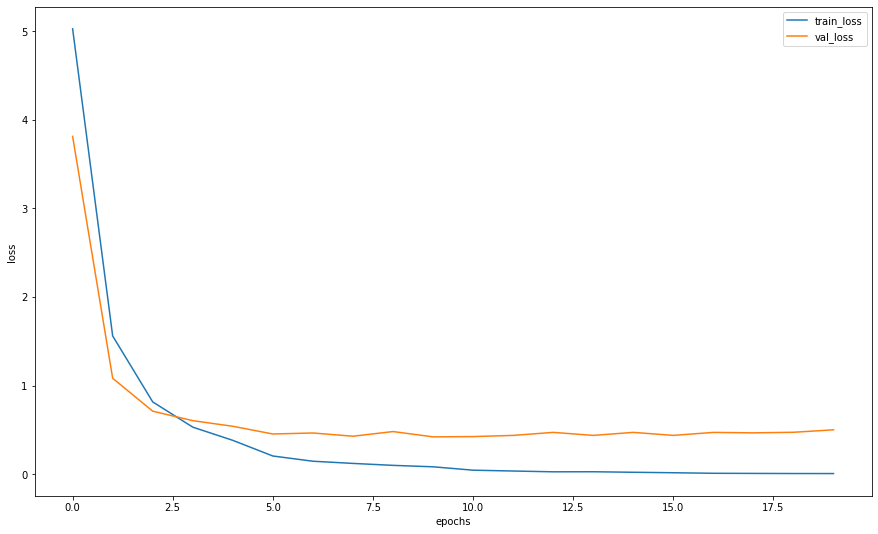

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

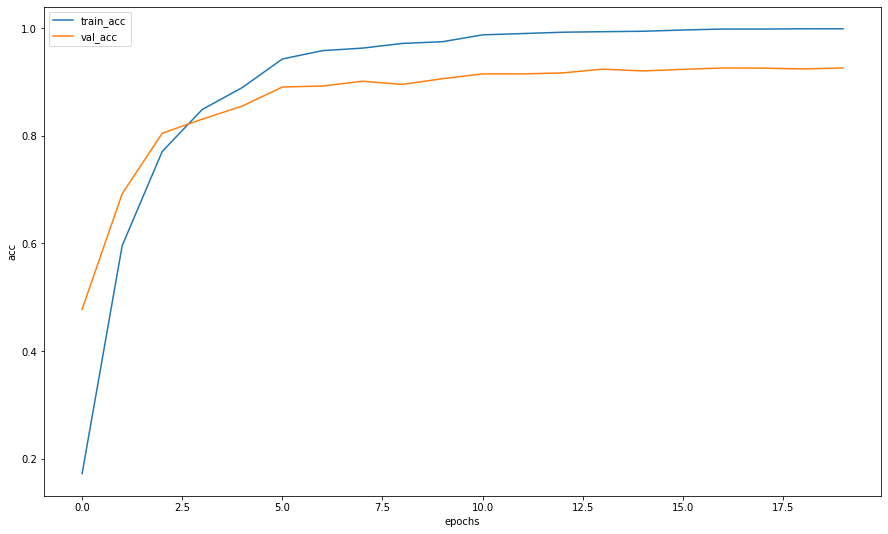

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

### Score

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)



In [ ]:
actual_labels = [val_dataset[id][1] for id in idxs]
#preds_class =label_encoder.transform(preds_class)
preds_class = [i for i in y_pred]
# [label_encoder.classes_[i] for i in y_pred]
print(actual_labels)

print(preds_class)


[15, 11, 7, 2, 2, 0, 15, 7, 10, 0, 15, 14, 3, 2, 2, 4, 7, 6, 4, 8]
[20, 11, 7, 2, 2, 0, 15, 7, 10, 0, 15, 14, 3, 2, 2, 4, 7, 6, 4, 8]


In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, list(preds_class),average='macro')


0.9

### Visualization

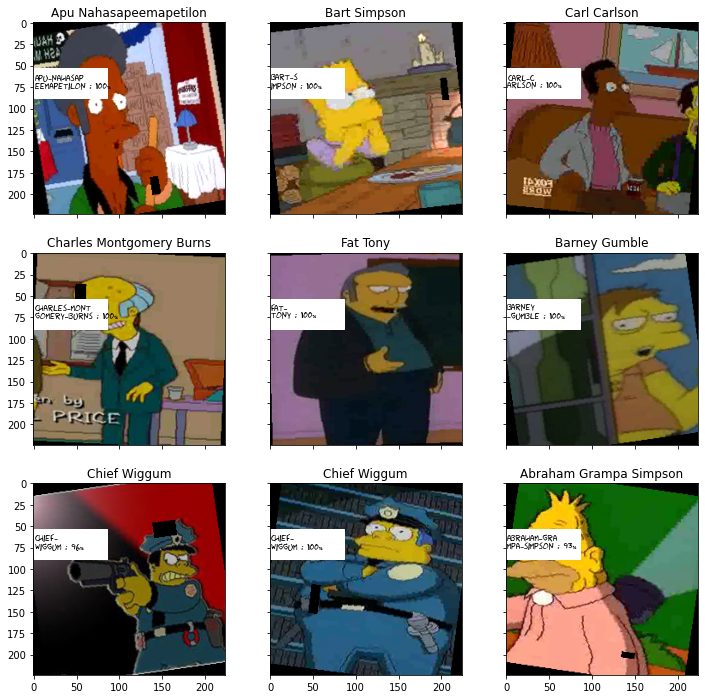

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit 

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
#df.to_csv('gdrive/My Drive/simpsons_simple_cnn_baselineMYSUBM.csv', index=False)
df.to_csv("submission.csv", index=False)

In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  testset
gdrive			     sample_data	submission.csv	       train
